# Inference demo

In this notebook, we will demonstrate an explainable machine learning framework based on XGBoost and SHAP from the work *Explainable Machine Learning for the Prediction and Assessment of Complex Drought Impacts*. The preliminary work was accepted at the NeurIPS 2020 Workshop Tackling Climate Change with Machine Learning ([*here*](https://arxiv.org/abs/2211.02768)) and the full work was published at  ...

The demonstration will use two cases: **the drought impacts on economy in Colorado and on fire in California**. The pretrained and tuned models, as well as the corresponding datasets, are hosted in this [public Google Drive folder](https://drive.google.com/drive/folders/1VClF7i142dKaalXciYRxYI2mNLb0VL2I?usp=sharing) and are also available at this [GitHub repository](https://github.com/bzhang9683/XAI_Drought_Impacts.git). If you are interested in playing with more models and datasets, please get in touch with the authors by email: <beichen@huskers.unl.edu>.

# Prepare the environment and get the data ready

In [1]:
# The models were trained and run with GPU
# To enable your notebook to run with GPU, go to Edit at the navigation bar
# then in the drop-down options open the Notebook settings, choose the hardware
# accelerator to GPU

!nvidia-smi

Sun Nov 13 20:33:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install and import these python libraries

In [2]:
! pip install --quiet xgboost==1.6.0 shap==0.40.0 scikit-learn==1.0.2 pandas seaborn matplotlib joblib==1.1.0 numpy==1.21.6

     |████████████████████████████████| 193.7 MB 43 kB/s 
     |████████████████████████████████| 564 kB 65.6 MB/s 
     |████████████████████████████████| 306 kB 75.5 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import seaborn as sns
import xgboost as xgb
import shap
from sklearn import model_selection
from sklearn import metrics
import joblib

## Get the data

If you’re running this tutorial in **Google Colab** you need to *'add a shortcut to your Google Drive’* from our [public Google Drive folder](https://drive.google.com/drive/folders/1VClF7i142dKaalXciYRxYI2mNLb0VL2I?usp=sharing) and mount that directory with the following code:

In [4]:
from google.colab import drive
import os
drive.mount('/content/drive')

public_folder = '/content/drive/My Drive/XAI_DroughtImpacts'
assert os.path.exists(public_folder), "Add a shortcut to the publice Google Drive folder: https://drive.google.com/drive/folders/1VClF7i142dKaalXciYRxYI2mNLb0VL2I?usp=sharing"

Mounted at /content/drive


Otherwise, if you're running locally in a jupyter notebook, you would download the data from the [public Google Drive folder](https://drive.google.com/drive/folders/1VClF7i142dKaalXciYRxYI2mNLb0VL2I?usp=sharing) or [GitHub repository](https://github.com/bzhang9683/XAI_Drought_Impacts.git) manually.

## Load the data
Loading the data from the Google Drive shortcut or your local directory

In [5]:
# change the directories to your local paths if you're running in a jupyter notebook
# load the csv files of the datasets
ca_fire = pd.read_csv('/content/drive/My Drive/XAI_DroughtImpacts/California_Fire.csv',index_col=0)
ca_features = pd.read_csv('/content/drive/My Drive/XAI_DroughtImpacts/California_features.csv',index_col=0)
co_econ = pd.read_csv('/content/drive/My Drive/XAI_DroughtImpacts/Colorado_Economy.csv',index_col=0)
co_features = pd.read_csv('/content/drive/My Drive/XAI_DroughtImpacts/Colorado_features.csv',index_col=0)

In [12]:
# demo, employed features in California
ca_features.head(5)

,SPI01,SPI03,SPI06,SPI09,SPI12,SPI18,SPI24,SPI36,SPI48,STI01,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
6001,-0.830073,0.170458,0.123568,0.130014,0.116310,0.331153,0.328719,-0.581566,-0.593116,-0.314452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6001,0.387962,0.141754,0.172803,0.133785,0.299332,0.346406,0.166571,-0.423917,-0.593963,-1.231284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6001,1.159256,0.307527,0.607155,0.574489,0.824824,0.591454,0.487314,0.028395,-0.204909,-1.122979,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6001,-1.055863,0.625512,0.422893,0.384971,0.392637,0.251280,0.477637,0.051991,-0.248256,-1.119181,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6001,0.686898,0.739745,0.415755,0.414334,0.384952,0.466490,0.482278,0.115907,-0.204552,-1.830571,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# demo, drought impacts on fire California (before binarization)
ca_fire.head(5)

,State_NAME,County_NAME,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,...,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
GEOID,,,,,,,,,,,,,,,,,,,,,
6001,California,Alameda,0,0,0,0,0,0,0,0,...,2,2,2,2,2,4,2,2,2,2
6003,California,Alpine,0,0,0,0,0,0,0,0,...,2,2,2,2,2,4,2,2,2,2
6005,California,Amador,0,0,0,0,0,0,0,0,...,2,2,2,2,2,4,2,2,2,2
6007,California,Butte,0,0,0,0,0,0,0,0,...,2,2,2,2,2,4,2,2,2,2
6009,California,Calaveras,0,0,0,0,0,0,0,0,...,2,2,2,2,2,4,2,2,2,2


In [66]:
# demo, drought impacts on fire California (after binarization)
ca_fire_dummy = ca_fire.iloc[:,2:].astype(bool).astype(int)
ca_fire_dummy.head(5)


,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,...,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
GEOID,,,,,,,,,,,,,,,,,,,,,
6001,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
6003,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
6005,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
6007,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
6009,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [67]:
# vectorize and ready to use
idx = ca_fire_dummy.index.values
ca_fire_dummy = ca_fire_dummy.values.flatten() # flatten the impact occurrence to a vector
df_ca_fire_dummy = pd.DataFrame({"Impacts": ca_fire_dummy}, index=np.repeat(idx,120,axis=0))

In [68]:
# get the dataset of drought impacts on economy in Colorado ready to use

co_econ_dummy = co_econ.iloc[:,2:].astype(bool).astype(int)
idx = co_econ_dummy.index.values
co_econ_dummy = co_econ_dummy.values.flatten() # flatten the impact occurrence to a vector
df_co_econ_dummy = pd.DataFrame({"Impacts": co_econ_dummy}, index=np.repeat(idx,120,axis=0))


# Run the framework

## Load and run the pretrained model

In [13]:
# randomly split the data, but we will only use the test dataset because
# the models were pretrained and tuned
# California
X_train_ca, X_test_ca, y_train_ca, y_test_ca = model_selection.train_test_split(ca_features, df_ca_fire_dummy, random_state=42, 
                                                                                test_size=0.3, stratify=ca_fire_dummy)
# Colorado
X_train_co, X_test_co, y_train_co, y_test_co = model_selection.train_test_split(co_features, df_co_econ_dummy, random_state=42, 
                                                                                test_size=0.3, stratify=co_econ_dummy)


In [14]:
# load the pretrained and tuned model
ca_fire_model = joblib.load('/content/drive/MyDrive/XAI_DroughtImpacts/California_Fire.joblib')
co_econ_model = joblib.load('/content/drive/My Drive/XAI_DroughtImpacts/Colorado_Economy.joblib')

In [15]:
# make predictions on the test datasets
# CA Fire
pred_ca_fire = ca_fire_model.predict(X_test_ca)
# CO Economy
pred_co_econ = co_econ_model.predict(X_test_co)

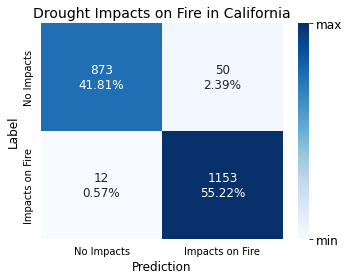

In [70]:
# Confusion matrix on predicting droought impacts on fire in California
ca_fire_cm = metrics.confusion_matrix(y_test_ca, pred_ca_fire)

min_val = np.min(ca_fire_cm)
max_val = np.max(ca_fire_cm)

group_counts = ['{0:0.0f}'.format(value) for value in
                ca_fire_cm.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in ca_fire_cm.flatten()/np.sum(ca_fire_cm)]

labels = [f'{v2}\n{v3}' for v2, v3 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(1,1,figsize=(5,4))
sns.heatmap(ca_fire_cm, annot=labels, fmt="", 
            cmap="Blues",
            annot_kws={"size": 12},
            yticklabels=["No Impacts", "Impacts on Fire"],
            vmin=min_val, vmax=max_val,
            cbar_kws={"ticks":[min_val,max_val]},
            ax=ax)
ax.collections[0].colorbar.set_ticklabels(['min', 'max'])
ax.collections[0].colorbar.ax.tick_params(labelsize=12)
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(["No Impacts", "Impacts on Fire"],fontsize=10)
ax.set_yticks([0.5,1.5])
ax.set_yticklabels(["No Impacts", "Impacts on Fire"],fontsize=10)
ax.set_xlabel("Prediction",fontsize=12)
ax.set_ylabel("Label",fontsize=12)
ax.set_title("Drought Impacts on Fire in California",fontsize=14)
plt.tick_params(left=False,bottom = False)
plt.tight_layout()
plt.show()

In [18]:
# Metrics of the model on the test dataset of California
f2_score = metrics.fbeta_score(y_test_ca, pred_ca_fire, beta=2)
recall = metrics.recall_score(y_test_ca, pred_ca_fire)
precision = metrics.precision_score(y_test_ca, pred_ca_fire)
print("The F2 score of the XGBoost model on predicting drought impacts on fire in California is %.2f,\
\nand the recall is %.2f, the precision is %.2f" %(f2_score,recall,precision))

The F2 score of the XGBoost model on predicting drought impacts on fire in California is 0.98,
and the recall is 0.99, the precision is 0.96


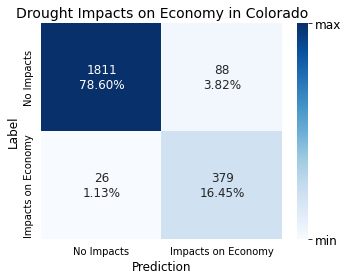

In [69]:
# Confusion matrix on predicting droought impacts on fire in Colorado
co_econ_cm = metrics.confusion_matrix(y_test_co, pred_co_econ)

min_val = np.min(co_econ_cm)
max_val = np.max(co_econ_cm)

group_counts = ['{0:0.0f}'.format(value) for value in
                co_econ_cm.flatten()]

group_percentages = ['{0:.2%}'.format(value) for value in co_econ_cm.flatten()/np.sum(co_econ_cm)]

labels = [f'{v2}\n{v3}' for v2, v3 in zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(1,1,figsize=(5,4))
sns.heatmap(co_econ_cm, annot=labels, fmt="", 
            cmap="Blues",
            annot_kws={"size": 12},
            yticklabels=["No Impacts", "Impacts on Fire"],
            vmin=min_val, vmax=max_val,
            cbar_kws={"ticks":[min_val,max_val]},
            ax=ax)
ax.collections[0].colorbar.set_ticklabels(['min', 'max'])
ax.collections[0].colorbar.ax.tick_params(labelsize=12)
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(["No Impacts", "Impacts on Economy"],fontsize=10)
ax.set_yticks([0.5,1.5])
ax.set_yticklabels(["No Impacts", "Impacts on Economy"],fontsize=10)
ax.set_xlabel("Prediction",fontsize=12)
ax.set_ylabel("Label",fontsize=12)
ax.set_title("Drought Impacts on Economy in Colorado",fontsize=14)
plt.tick_params(left=False,bottom = False)
plt.tight_layout()
plt.show()

In [20]:
# Metrics of the model on the test dataset
f2_score = metrics.fbeta_score(y_test_co, pred_co_econ, beta=2)
recall = metrics.recall_score(y_test_co, pred_co_econ)
precision = metrics.precision_score(y_test_co, pred_co_econ)
print("The F2 score of the XGBoost model on predicting drought impacts on economy in Colorado is %.2f,\
\nand the recall is %.2f, the precision is %.2f" %(f2_score,recall,precision))

The F2 score of the XGBoost model on predicting drought impacts on economy in Colorado is 0.91,
and the recall is 0.94, the precision is 0.81


## Computing the SHAP values

In [21]:
# build the tree explainer
explainer_ca_fire = shap.TreeExplainer(ca_fire_model)
explainer_co_econ = shap.TreeExplainer(co_econ_model)

In [22]:
shap_val_ca_fire = explainer_ca_fire.shap_values(X_test_ca) # calculate shap values
shap_val_co_econ = explainer_co_econ.shap_values(X_test_co) # calculate shap values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### SHAP summary (beeswarm) plots

#### California, impacts on fire

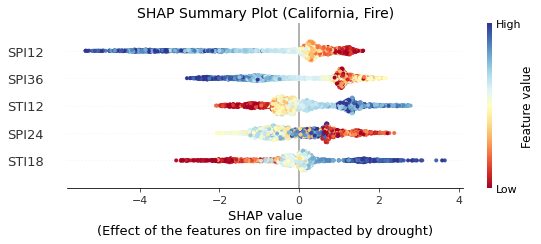

In [23]:
# the top five important features for predicting drought impacts on fire in California
plt.figure()
CustomCmap = plt.get_cmap("RdYlBu")
shap.summary_plot(shap_val_ca_fire, X_test_ca, plot_type="dot", max_display = 5, color=CustomCmap,show=False)

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(CustomCmap)
plt.title("SHAP Summary Plot (California, Fire)",fontsize=14)
plt.xlabel("SHAP value\n(Effect of the features on fire impacted by drought)")
plt.tight_layout()
plt.show()

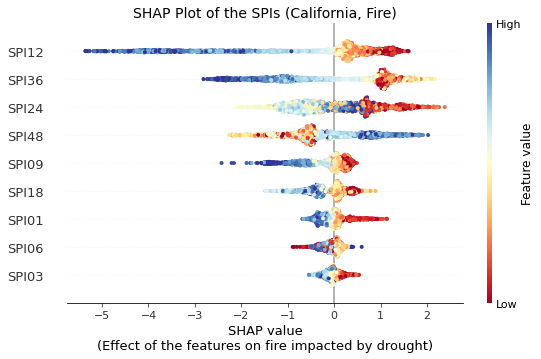

In [24]:
# how do the SPIs affect the model?
# blue => high positive precipitation anomalies (too wet)
# red => low negative precipitation anomalies (too dry)
plt.figure()
CustomCmap = plt.get_cmap("RdYlBu")
shap.summary_plot(shap_val_ca_fire[:,:9], X_test_ca.iloc[:,:9], plot_type="dot", color=CustomCmap,show=False)

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(CustomCmap)
plt.title("SHAP Plot of the SPIs (California, Fire)",fontsize=14)
plt.xlabel("SHAP value\n(Effect of the features on fire impacted by drought)")
plt.tight_layout()
plt.show()

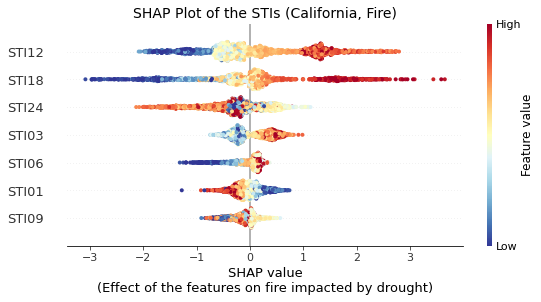

In [25]:
# how do the STIs affect the model?
# red => high positive temperature anomalies (too hot)
# blue => low negative temperature anomalies (too cold)
plt.figure()
CustomCmap = plt.get_cmap("RdYlBu_r")
shap.summary_plot(shap_val_ca_fire[:,9:16], X_test_ca.iloc[:,9:16], plot_type="dot", color=CustomCmap,show=False)

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(CustomCmap)
plt.title("SHAP Plot of the STIs (California, Fire)",fontsize=14)
plt.xlabel("SHAP value\n(Effect of the features on fire impacted by drought)")
plt.tight_layout()
plt.show()

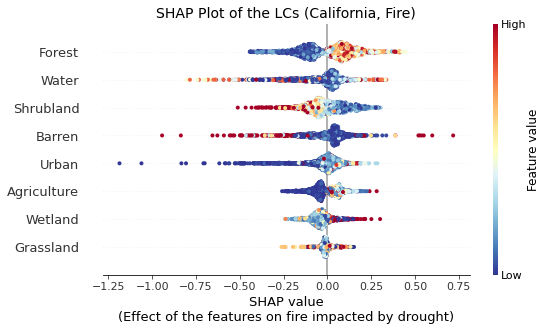

In [26]:
# how do the LCs affect the model?
# red => high land coverage
# blue => low land coverage
plt.figure()
CustomCmap = plt.get_cmap("RdYlBu_r")
shap.summary_plot(shap_val_ca_fire[:,16:24], X_test_ca.iloc[:,16:24], plot_type="dot", color=CustomCmap,show=False)

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(CustomCmap)
plt.title("SHAP Plot of the LCs (California, Fire)",fontsize=14)
plt.xlabel("SHAP value\n(Effect of the features on fire impacted by drought)")
plt.tight_layout()
plt.show()

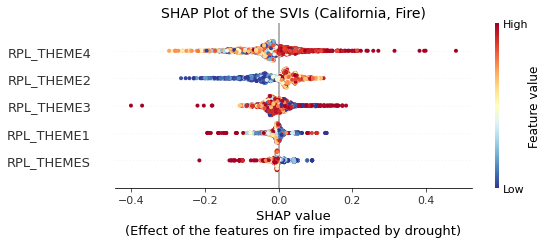

In [27]:
# how do the SVIs affect the model?
# red => high vulnerability (percentile ranking)
# blue => low vulnerability (percentile ranking)
plt.figure()
CustomCmap = plt.get_cmap("RdYlBu_r")
shap.summary_plot(shap_val_ca_fire[:,24:29], X_test_ca.iloc[:,24:29], plot_type="dot", color=CustomCmap,show=False)

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(CustomCmap)
plt.title("SHAP Plot of the SVIs (California, Fire)",fontsize=14)
plt.xlabel("SHAP value\n(Effect of the features on fire impacted by drought)")
plt.tight_layout()
plt.show()

#### Colorado, impacts on economy

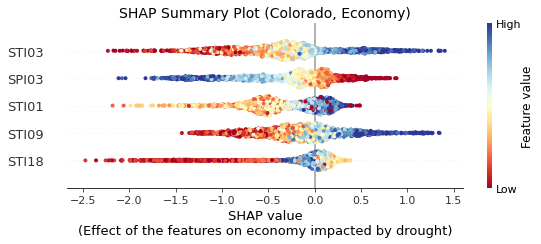

In [28]:
# the top five important features for predicting drought impacts on economy in Colorado
plt.figure()
CustomCmap = plt.get_cmap("RdYlBu")
shap.summary_plot(shap_val_co_econ, X_test_co, plot_type="dot", max_display = 5, color=CustomCmap,show=False)
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(CustomCmap)
plt.title("SHAP Summary Plot (Colorado, Economy)",fontsize=14)
plt.xlabel("SHAP value\n(Effect of the features on economy impacted by drought)")
plt.tight_layout()
plt.show()

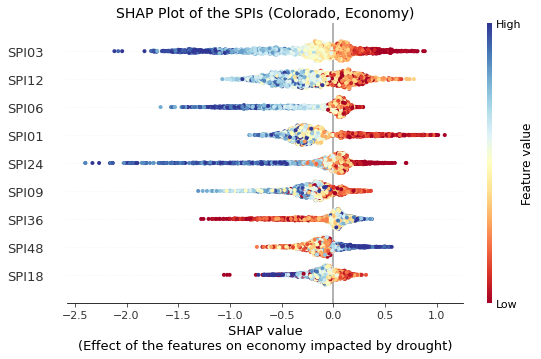

In [29]:
# how do the SPIs affect the model?
# blue => high positive precipitation anomalies (too wet)
# red => low negative precipitation anomalies (too dry)
plt.figure()
CustomCmap = plt.get_cmap("RdYlBu")
shap.summary_plot(shap_val_co_econ[:,:9], X_test_co.iloc[:,:9], plot_type="dot", color=CustomCmap,show=False)

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(CustomCmap)
plt.title("SHAP Plot of the SPIs (Colorado, Economy)",fontsize=14)
plt.xlabel("SHAP value\n(Effect of the features on economy impacted by drought)")
plt.tight_layout()
plt.show()

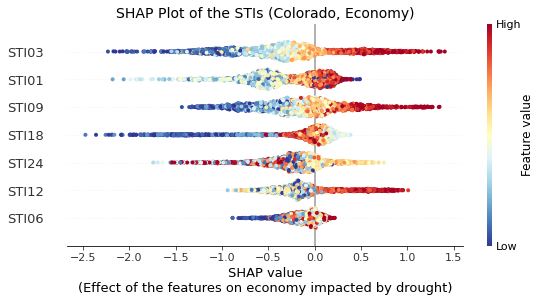

In [30]:
# how do the STIs affect the model?
# red => high positive temperature anomalies (too hot)
# blue => low negative temperature anomalies (too cold)
plt.figure()
CustomCmap = plt.get_cmap("RdYlBu_r")
shap.summary_plot(shap_val_co_econ[:,9:16], X_test_co.iloc[:,9:16], plot_type="dot", color=CustomCmap,show=False)

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(CustomCmap)
plt.title("SHAP Plot of the STIs (Colorado, Economy)",fontsize=14)
plt.xlabel("SHAP value\n(Effect of the features on economy impacted by drought)")
plt.tight_layout()
plt.show()

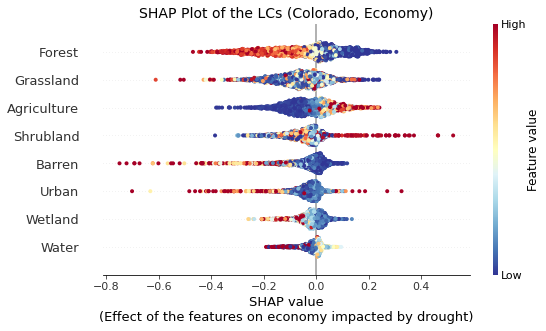

In [31]:
# how do the LCs affect the model?
# red => high land coverage
# blue => low land coverage
plt.figure()
CustomCmap = plt.get_cmap("RdYlBu_r")
shap.summary_plot(shap_val_co_econ[:,16:24], X_test_co.iloc[:,16:24], plot_type="dot", color=CustomCmap,show=False)

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(CustomCmap)
plt.title("SHAP Plot of the LCs (Colorado, Economy)",fontsize=14)
plt.xlabel("SHAP value\n(Effect of the features on economy impacted by drought)")
plt.tight_layout()
plt.show()

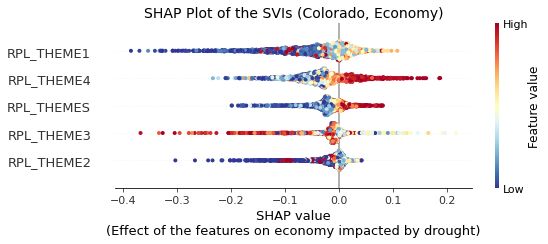

In [33]:
# how do the SVIs affect the model?
# red => high vulnerability (percentile ranking)
# blue => low vulnerability (percentile ranking)
plt.figure()
CustomCmap = plt.get_cmap("RdYlBu_r")
shap.summary_plot(shap_val_co_econ[:,24:29], X_test_co.iloc[:,24:29], plot_type="dot", color=CustomCmap,show=False)

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(CustomCmap)
plt.title("SHAP Plot of the SVIs (Colorado, Economy)",fontsize=14)
plt.xlabel("SHAP value\n(Effect of the features on economy impacted by drought)")
plt.tight_layout()
plt.show()

### SHAP dependence (scatter) plots
Since the paper already used the impacts on fire in California as a case day, here we used the impacts on economy in Colorado as the demo

In [34]:
shap_co_ind = shap.TreeExplainer(co_econ_model,X_test_co)
shap_val_co_ind = shap_co_ind(X_test_co)

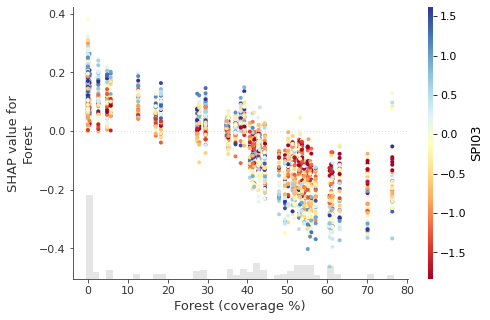

In [43]:
# interaction between Forest and SPI3
CustomCmap = plt.get_cmap('RdYlBu')
shap.plots.scatter(shap_val_co_ind[:,"Forest"], color=shap_val_co_ind[:,"SPI03"],cmap=CustomCmap,show=False)
plt.xlabel("Forest (coverage %)")
plt.show()

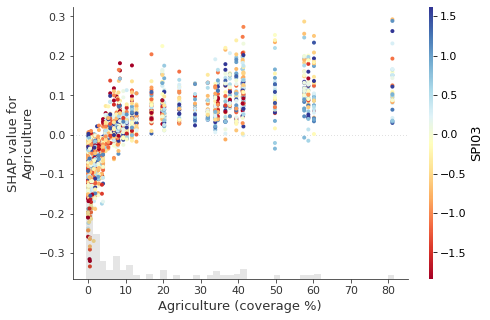

In [42]:
# interaction between Agriculture and SPI3
CustomCmap = plt.get_cmap('RdYlBu')
shap.plots.scatter(shap_val_co_ind[:,"Agriculture"], color=shap_val_co_ind[:,"SPI03"],cmap=CustomCmap,show=False)
plt.xlabel("Agriculture (coverage %)")
plt.show()

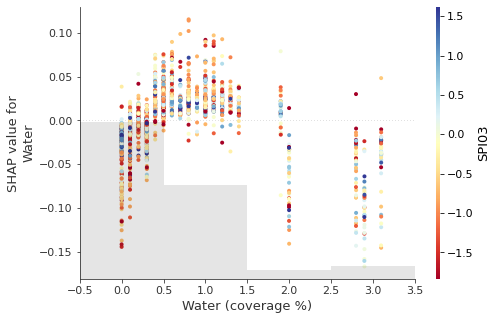

In [41]:
# interaction between Water and SPI3
CustomCmap = plt.get_cmap('RdYlBu')
shap.plots.scatter(shap_val_co_ind[:,"Water"], color=shap_val_co_ind[:,"SPI03"],cmap=CustomCmap,show=False)
plt.xlabel("Water (coverage %)")
plt.show()

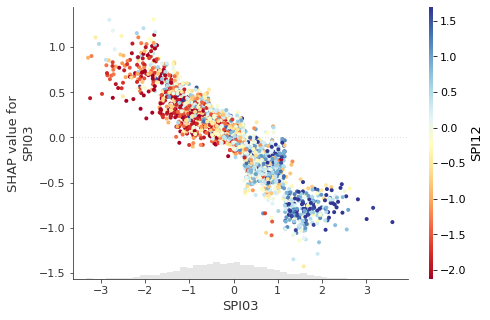

In [37]:
# interaction between SPI03 and SPI12
CustomCmap = plt.get_cmap('RdYlBu')
shap.plots.scatter(shap_val_co_ind[:,"SPI03"], color=shap_val_co_ind[:,"SPI12"],cmap=CustomCmap,show=False)
plt.show()

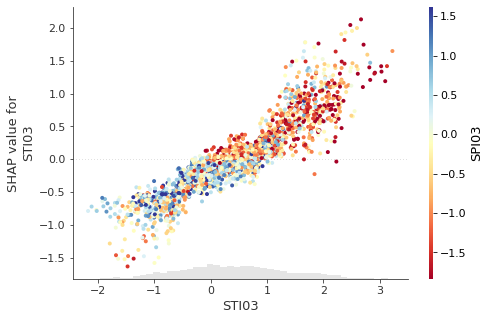

In [36]:
# interaction between SPI03 and STI03
CustomCmap = plt.get_cmap('RdYlBu')
shap.plots.scatter(shap_val_co_ind[:,"STI03"], color=shap_val_co_ind[:,"SPI03"],cmap=CustomCmap,show=False)
plt.show()

Here are some addtional SHAP scatter plots that are the SHAP interaction plot (pure interaction effects) and the SHAP main effect plot (individual effects)

In [63]:
shap_interaction_values = explainer_co_econ.shap_interaction_values(X_test_co)

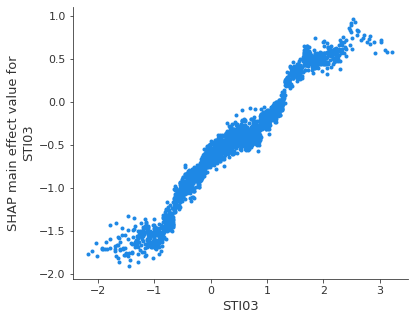

In [57]:
# SHAP main effect plot
shap.dependence_plot(("STI03", "STI03"), shap_interaction_values, X_test_co)

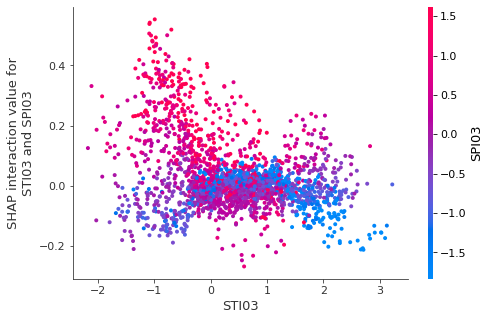

In [62]:
# SHAP interaction plot
shap.dependence_plot(("STI03", "SPI03"), shap_interaction_values, X_test_co)